<div style="text-align: center;">
  <img src="https://github.com/Hack-io-Data/Imagenes/blob/main/01-LogosHackio/logo_naranja@4x.png?raw=true" alt="esquema" />
</div>

# Laboratorio: Construcción Modelo de Clasificación y Evaluación de Métricas

Tras realizar el preprocesamiento de los datos y dejarlos listos para construir modelos, ha llegado el momento de dar el siguiente paso: desarrollar tu **primer modelo de clasificación**.

El objetivo de este laboratorio es implementar un modelo de clasificación inicial utilizando **Regresión Logística (Logistic Regression)**. Este modelo te permitirá obtener las primeras predicciones para identificar transacciones normales y anómalas, así como evaluar su desempeño utilizando métricas estándar.

Además, deberás evaluar si el modelo está en riesgo de **overfitting**, asegurando que nuestras predicciones sean consistentes tanto en los datos de entrenamiento como en los de prueba.


## Objetivo del Laboratorio

1. Entrenar un modelo de **Regresión Logística** para predecir si una transacción es "Normal" o "Anómala".

2. Evaluar el desempeño del modelo utilizando métricas como:

   - Precisión (Accuracy).

   - Matriz de confusión.

   - Precisión (Precision), exhaustividad (Recall) y F1-Score.

   - Área bajo la curva ROC (AUC-ROC).

3. Determinar si el modelo presenta **overfitting** o **underfitting**, analizando el rendimiento en los datos de entrenamiento y prueba.


### 0. Import functions

In [46]:
%load_ext autoreload
%autoreload 2

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import roc_curve, auc

import sys
sys.path.append("..")
import src.soporte_ajuste_logistica as sal


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## 1. Import data

First, it is necessary to import the data preprocessed from yesterday.

In [ ]:
financial_df = pd.read_pickle("../datos/financial_df_preprocesado.pkl")

# 2. Cv and train model

In [74]:
# define CV framework
cv = StratifiedKFold(n_splits=5)

# instantiate object for model classification
analizador_clasificacion = sal.AnalisisModelosClasificacion(financial_df, "is_fraudulent")

# fit the model
analizador_clasificacion.ajustar_modelo("logistic_regression", cross_validation=cv)

# 3. Analyse metrics

,train,test
accuracy,0.561250,0.567500
precision,0.561194,0.567129
recall,0.561250,0.567500
f1,0.561060,0.567195
kappa,0.122183,0.133143
auc,0.585770,0.596810


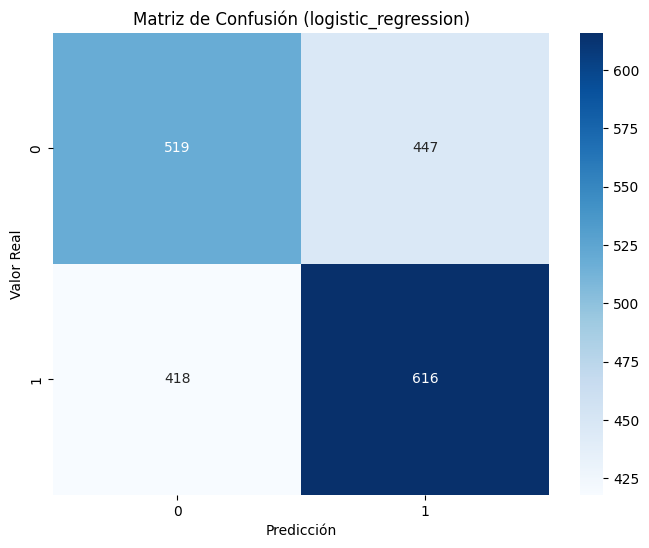

In [75]:
# check metrics
display(analizador_clasificacion.calcular_metricas("logistic_regression"))
analizador_clasificacion.plot_matriz_confusion("logistic_regression")

Given the results above, looking at the confusion matrix, it looks our model is not performing very well, as samples in the FP and FN quares are very close to those in the TP and TN ones.

Before going over the metrics meaning, let's calculate again the base imbalance in the model:

In [72]:
print(f"The base accuracy for the model is {financial_df['is_fraudulent'].mean()*100}%")

The base accuracy for the model is 50.68%


The imbalance above means that 50.68% of records are fraudulent. This means that if we only predicted the value fraudulent for this dataset, we would be right 50.68% of the time, and thus if our model yields this accuracy, our model is not better than just predicting the same value. That value serves as a baseline for accuracy.

Let's explain what the metrics above the confusion matrix are saying:
- **In general**. Our model has no overitting, but instead it is probably underfitting as it does not perform too well in terms of accuracy, kappa or AUC.
- **Accuracy.** Not clear, as we have 56% accuracy, but a naive model get's us 50.68%.
- **Precision** and **Recall** have almost equal values. In this case, Recall would be the metric to pay special attention to, as it captures how many of the transactions that are actually fraudulent are predicted as such. 
- **f1-score**. It summarizes how well our model is performing in terms of both precision and recall. Its value is very similar to the above metrics because both precision and recall are very similar. This is not the metric of interest, as we would probably give more importance to recall to pay more attention to how well we are predicting positive values.
- **kappa**. Kappa summarizes how well the model is improving upon a model that just predicts the majority class or upon plain luck. Studying accuracy we said that we should improve upon the baseline accuracy of 50.68%. Kappa straight away gives a summarized information of how well the model is predicting better in general.

All above informations measure the perfomance of the model for a given prediction threshold, in this case the default 0.5. That means that they information they provide speak about a specific configuration of the model, the threshold. To better assess models, we would need to look at every given point's f1-score, if we are interested in a balance between TPR and FPR. For that purpose, it is interesting to look at each model's ROC curve and visually inspect if there is a point that strikes the desired balance or, more simply, just looking at a metric that summarizes it:

- **AUC**. Summarizes the performance of our model's TPR Vs. FPR at every ROC curve point, which is more independant of imbalance than accuracy and tells which model performs better overall, allowing to choose one and then optimize the prediction threshold for that model.

In conclusion, metrics to compare in our case:
- **AUC**. To decide which model does better overall in the tradeoff between TPR and FPR.
- **Recall** vs Precision balance. Recall is more important for this problem, but we probably would like to not block all transaction, so we would have to monitor precision too.
- **Kappa**. Good to assess whether our model, at a given threshold, is doing better than a plain luck model.

Let's plot the ROC curve to see if there is a point in it that could hold an optimal threshold:

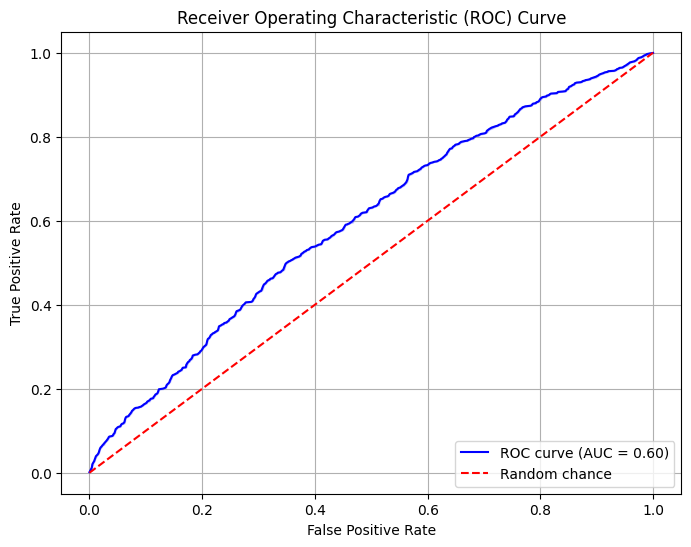

In [73]:
# retrieve y_pred and y_test from analizador_clasificacion object
y_test_pred_prob = analizador_clasificacion.resultados["logistic_regression"]["pred_test_prob"]
y_test = analizador_clasificacion.y_test

fpr, tpr, thresholds = roc_curve(y_test, y_test_pred_prob)

# calculate FPR and TPR
fpr, tpr, thresholds = roc_curve(y_test, y_test_pred_prob)

# calculate AUC score for the ROC curve
roc_auc = auc(fpr, tpr)

# plot roc curve
plt.figure(figsize=(8, 6))
sns.lineplot(x=fpr, y=tpr, color='blue', label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='red', linestyle='--', label='Random chance')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.grid()
plt.show()

Looking at the area under the curve value we see that the model does not perform a lot better than the random chance one. The progression of the ROC is quite smooth, indicating that there is no point where we can get more TPR without incurring in FPR for 'free'.

Finally, if we wanted to take this model and optimize it as much as possible, we would need to stablish a 'weight' for FN and FP, in terms of money (through fraudulent transaction loss, for example) to find the threshold that meets our criteria.